In [12]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
from model import UNet, DoubleConv
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

# Set random seeds
from utils import (
    DiceBCELoss,
    train_epoch,
    validate_epoch,
    EarlyStopping
)

# Set random seeds
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True


Using device: cuda


In [33]:
# ============================================================================\n
# CONFIGURATION (Updated for Task 2)
# ============================================================================\n
train_file = 'train.txt'
val_file = 'val.txt'

class Config:
    # Dataset paths
    DATASET_PATH = "data\\kvasir-seg"
    IMAGE_DIR = "images"
    MASK_DIR = "masks"
    
    # Experiment parameters
    # RESOLUTIONS = [512, 256, 128, 64] # <-- Removed/Commented out (Task 1 only)
    TARGET_SIZE = 256
    
    # Training parameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 5 
    # LR Scheduler
    SCHEDULER_PATIENCE = 3 
    SCHEDULER_FACTOR = 0.1 
    
    # Model parameters
    IN_CHANNELS = 3
    OUT_CHANNELS = 1
    FEATURES = [64, 128, 256, 512]
    
config = Config()

# AUGMENTATION_TYPE = "hflip" 

In [34]:
class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=256, augmentation_type=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        
        # Base transforms (always applied)
        base_transforms = [
            A.Resize(height=target_size, width=target_size, interpolation=cv2.INTER_LINEAR),
        ]
        
        # Add augmentation based on type
        if augmentation_type == 'hflip':
            aug_transforms = [A.HorizontalFlip(p=0.5)]
        elif augmentation_type == 'vflip':
            aug_transforms = [A.VerticalFlip(p=0.5)]
        elif augmentation_type == 'rotate':
            aug_transforms = [A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, 
                                      border_mode=cv2.BORDER_REFLECT_101, p=0.7)]
        elif augmentation_type == 'colorjitter':
            aug_transforms = [A.ColorJitter(brightness=0.2, contrast=0.2, 
                                           saturation=0.2, hue=0.1, p=0.7)]
        elif augmentation_type == 'all':
            aug_transforms = [
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                        border_mode=cv2.BORDER_REFLECT101, p=0.7),
                A.OneOf([
                    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
                    A.ColorJitter(brightness=0.2, contrast=0.2, 
                             saturation=0.2, hue=0.1, p=0.7)
                ],p=0.07)
            ]
        else:
            aug_transforms = []
        
        # Final transforms (always applied)
        final_transforms = [
            A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
            ToTensorV2()
        ]
        
        # Combine all transforms
        self.transform = A.Compose(base_transforms + aug_transforms + final_transforms)

    def __len__(self):  # <-- MAKE SURE YOU HAVE THIS!
        return len(self.image_paths)
    
    def __getitem__(self, idx):  # <-- AND THIS!
        # Load image and mask with cv2
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Binarize mask (0 or 1)
        mask = (mask > 128).astype(np.uint8)
        
        # Apply transforms
        augmented = self.transform(image=image, mask=mask)
        
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']
        
        # Add channel dimension to mask (H, W) -> (1, H, W)
        mask_tensor = mask_tensor.unsqueeze(0).float()
        
        return image_tensor, mask_tensor

In [35]:
# ============================================================================
# PATH COLLECTION AND VALIDATION
# ============================================================================

import os
from pathlib import Path

# Simple file existence check
if not os.path.exists('train.txt') or not os.path.exists('val.txt'):
    raise FileNotFoundError('train.txt or val.txt missing.')

base_path = Path(config.DATASET_PATH)
image_paths = sorted(list((base_path / config.IMAGE_DIR).glob('*.jpg')))
mask_paths = sorted(list((base_path / config.MASK_DIR).glob('*.jpg')))

if len(image_paths) != len(mask_paths):
    raise ValueError("Mismatch between number of images and masks.")

# Read train/val lists
with open('train.txt', 'r') as f:
    train_stems = {line.strip() for line in f}
with open('val.txt', 'r') as f:
    val_stems = {line.strip() for line in f}

# Split dataset according to txt files
train_images = [p for p in image_paths if p.stem in train_stems]
train_masks = [p for p in mask_paths if p.stem in train_stems]
val_images = [p for p in image_paths if p.stem in val_stems]
val_masks = [p for p in mask_paths if p.stem in val_stems]

print(f"Train: {len(train_images)} images, Val: {len(val_images)} images")


Train: 700 images, Val: 300 images


In [36]:
# ============================================================================
# MODEL CALL
# ============================================================================

def test_model_call():
    model = UNet(in_channels=3, out_channels=1).to(device)
    print("Model created successfully!")
    
    # Create a dummy input tensor
    dummy_input = torch.randn(1, 3, 256, 256).to(device)
    print(f"Input shape: {dummy_input.shape}")
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
    print(f"Output shape: {output.shape}")

test_model_call()

Model created successfully!
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


# Load dataset paths

In [37]:
# Check files exist
if not os.path.exists('train.txt') or not os.path.exists('val.txt'):
    raise FileNotFoundError('train.txt or val.txt missing!')

# Get all image and mask paths
base_path = Path(config.DATASET_PATH)
image_paths = sorted(list((base_path / config.IMAGE_DIR).glob('*.jpg')))
mask_paths = sorted(list((base_path / config.MASK_DIR).glob('*.jpg')))

if len(image_paths) != len(mask_paths):
    raise ValueError("Mismatch between images and masks!")

print(f"Found {len(image_paths)} images")

# Read train/val split
with open('train.txt', 'r') as f:
    train_stems = {line.strip() for line in f}
with open('val.txt', 'r') as f:
    val_stems = {line.strip() for line in f}

# Split dataset
train_images = [p for p in image_paths if p.stem in train_stems]
train_masks = [p for p in mask_paths if p.stem in train_stems]
val_images = [p for p in image_paths if p.stem in val_stems]
val_masks = [p for p in mask_paths if p.stem in val_stems]

# Print split info
print(f"Training:   {len(train_images)} images ({len(train_images)/(len(train_images)+len(val_images))*100:.1f}%)")
print(f"Validation: {len(val_images)} images ({len(val_images)/(len(train_images)+len(val_images))*100:.1f}%)")



Found 1000 images
Training:   700 images (70.0%)
Validation: 300 images (30.0%)


# Create dataloaders

In [40]:
print("\nCreating datasets...")

# Training dataset WITH AUGMENTATION
train_dataset = KvasirDataset(
    train_images, 
    train_masks, 
    target_size=config.TARGET_SIZE,
    augmentation_type = AUGMENTATION_TYPE
)

# Validation dataset WITHOUT AUGMENTATION
val_dataset = KvasirDataset(
    val_images, 
    val_masks, 
    target_size=config.TARGET_SIZE,
    augmentation_type = None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Creating datasets...
Training batches: 88
Validation batches: 38


# MAIN TRAINING LOOP (WITH LR SCHEDULING + EARLY STOPPING)

In [44]:
# ============================================================================
# AUTOMATED EXPERIMENT LOOP - RUNS ALL AUGMENTATIONS
# ============================================================================

# Define all experiments to run
experiments = [None, 'hflip', 'vflip', 'rotate', 'colorjitter', 'all']
experiment_results = {}

for AUGMENTATION_TYPE in experiments:
    
    # Determine save name
    aug_name = AUGMENTATION_TYPE if AUGMENTATION_TYPE else 'baseline'
    
    print("=" * 50)
    print(f"STARTING EXPERIMENT FOR AUGMENTATION: {aug_name.upper()}")
    print("=" * 50)
    
    # Re-create datasets for this experiment
    train_dataset = KvasirDataset(
        train_images, 
        train_masks, 
        target_size=config.TARGET_SIZE,
        augmentation_type=AUGMENTATION_TYPE
    )
    
    val_dataset = KvasirDataset(
        val_images, 
        val_masks, 
        target_size=config.TARGET_SIZE,
        augmentation_type=None
    )
    
    # Re-create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Initialize FRESH model for this experiment
    model = UNet(in_channels=config.IN_CHANNELS, 
                 out_channels=config.OUT_CHANNELS).to(device)
    
    # Loss function
    criterion = DiceBCELoss(weight_dice=0.5, weight_bce=0.5)
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=config.SCHEDULER_FACTOR,
        patience=config.SCHEDULER_PATIENCE,
        verbose=False  # Don't print LR changes
    )
    
    # Training history
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'lr': []
    }
    
    # Early stopping
    best_dice = 0
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop for this experiment
    for epoch in range(config.NUM_EPOCHS):
        
        # Training phase
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validation phase
        val_loss, val_dice, val_iou = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step(val_dice)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['lr'].append(current_lr)
        
        # Print single line format
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}.. "
              f"Train Loss: {train_loss:.4f}.. "
              f"Val Loss: {val_loss:.4f}.. "
              f"Val Dice: {val_dice:.4f}.. "
              f"Val IoU: {val_iou:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_dice = val_dice
            best_iou = val_iou
            patience_counter = 0
            print(f"Validation loss decreased ({val_dice:.4f}). Saving model...")
        else:
            patience_counter += 1
            print(f"EarlyStopping counter: {patience_counter} out of {config.EARLY_STOPPING_PATIENCE}")
        
        # Check early stopping
        if patience_counter >= config.EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered!")
            break
        
        experiment_results[aug_name] = {
            'val_loss': float(best_val_loss),
            'dice': float(best_dice),
            'iou': float(best_iou)
        }

STARTING EXPERIMENT FOR AUGMENTATION: BASELINE
Epoch 1/25.. Train Loss: 0.5302.. Val Loss: 0.5256.. Val Dice: 0.5567.. Val IoU: 0.3897
Validation loss decreased (0.5567). Saving model...
Epoch 2/25.. Train Loss: 0.4523.. Val Loss: 0.4312.. Val Dice: 0.6146.. Val IoU: 0.4487
Validation loss decreased (0.6146). Saving model...
Epoch 3/25.. Train Loss: 0.4159.. Val Loss: 0.6078.. Val Dice: 0.5377.. Val IoU: 0.3723
EarlyStopping counter: 1 out of 5
Epoch 4/25.. Train Loss: 0.3837.. Val Loss: 0.3936.. Val Dice: 0.6310.. Val IoU: 0.4676
Validation loss decreased (0.6310). Saving model...
Epoch 5/25.. Train Loss: 0.3606.. Val Loss: 0.3619.. Val Dice: 0.6561.. Val IoU: 0.4966
Validation loss decreased (0.6561). Saving model...
Epoch 6/25.. Train Loss: 0.3279.. Val Loss: 0.3271.. Val Dice: 0.6883.. Val IoU: 0.5339
Validation loss decreased (0.6883). Saving model...
Epoch 7/25.. Train Loss: 0.3022.. Val Loss: 0.3208.. Val Dice: 0.6931.. Val IoU: 0.5377
Validation loss decreased (0.6931). Saving 

KeyboardInterrupt: 

In [39]:
# Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(experiment_results, orient='index')
results_df.index.name = 'Augmentation'
results_df = results_df.sort_index()  # sort alphabetically (optional)

print("\n--- Final Augmentation Experiment Results ---")
print(results_df)

# Optional: Plot the results
results_df.plot(kind='bar', y=['dice', 'iou'],
                title='Segmentation Metrics by Augmentation Type',
                figsize=(10, 6))
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

NameError: name 'experiment_results' is not defined


--- Final Experiment Results ---
Augmentation    val_loss     dice         iou         


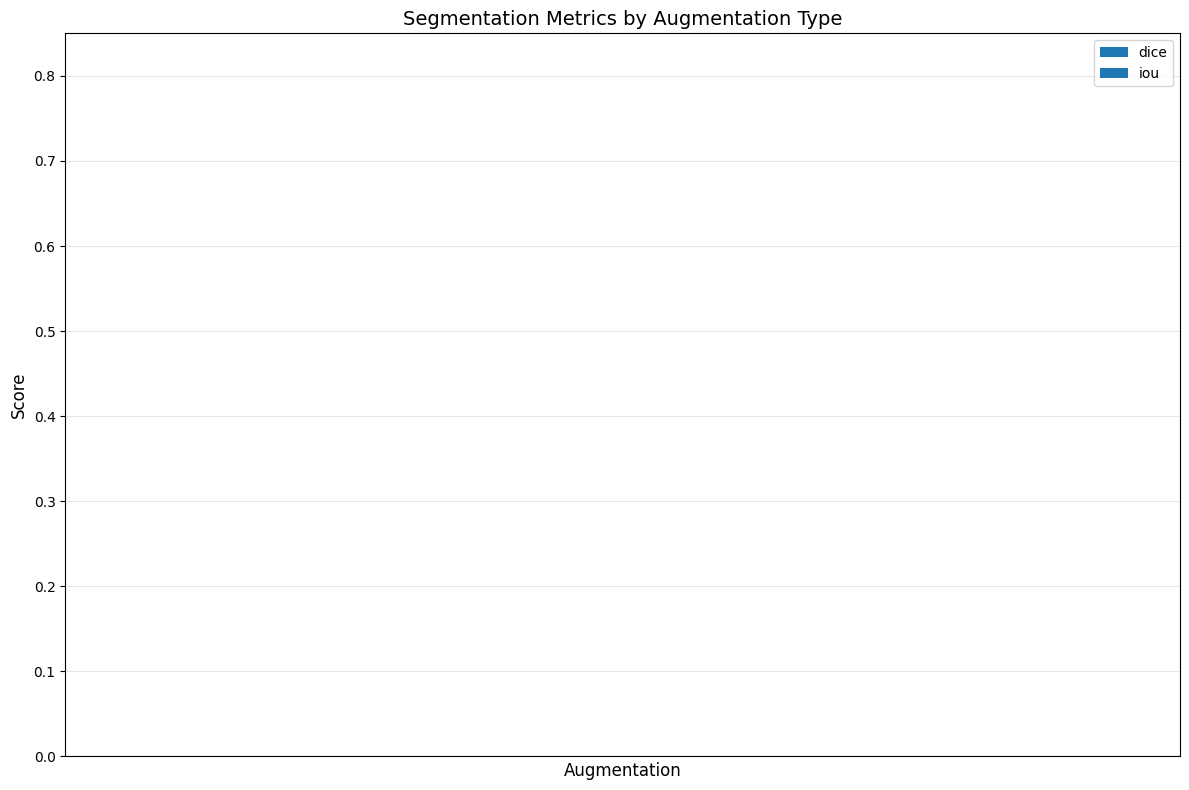

In [ ]:
# ============================================================================
# Display result COOKED
# ============================================================================

print("\n--- Final Experiment Results ---")
print(f"{'Augmentation':<15} {'val_loss':<12} {'dice':<12} {'iou':<12}")

# Sort by dice score (highest first)
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['dice'], reverse=True)

for aug_name, metrics in sorted_results:
    print(f"{aug_name:<15} {metrics['loss']:<12.6f} {metrics['dice']:<12.6f} {metrics['iou']:<12.6f}")

# Create comparison bar plot
fig, ax = plt.subplots(figsize=(12, 8))

augmentations = [item[0] for item in sorted_results]
dice_scores = [item[1]['dice'] for item in sorted_results]
iou_scores = [item[1]['iou'] for item in sorted_results]

x = np.arange(len(augmentations))
width = 0.35

bars1 = ax.bar(x - width/2, dice_scores, width, label='dice', color='#1f77b4')
bars2 = ax.bar(x + width/2, iou_scores, width, label='iou', color='#ff7f0e')

ax.set_xlabel('Augmentation', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Segmentation Metrics by Augmentation Type', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(augmentations)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Set y-axis limits
ax.set_ylim(0, 0.85)

plt.tight_layout()
plt.show()

# Save results (aner ikke om dette trengs)

In [ ]:
# Save training history to CSV
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_augmented.csv', index=False)
print("History saved as 'training_history_augmented.csv'")

print("\n" + "=" * 70)
print("ALL RESULTS SAVED!")
print("=" * 70)
print("\nGenerated files:")
print("  1. best_model_augmented.pth          - Best model checkpoint")
print("  2. training_history_augmented.csv    - All metrics per epoch")
print("  3. training_results_augmented.png    - Training curves")
print("=" * 70)
print("\nTASK 2 COMPLETE!")
print("Your experiment: Training WITH augmentation (8 techniques)")
print("Focus of report: How augmentation improves generalization")
print("=" * 70)
